In [ ]:
pip install face-recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=80e75e623a6365635e44bd3da01be84369ae2e008d29c9a9af2211b2274a1a9f
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
import cv2
import dlib
import numpy as np
import os
import urllib.request
import face_recognition
import hashlib
import dlib
import random
import shutil
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'
urllib.request.urlretrieve(url, 'haarcascade_frontalface_default.xml')

('haarcascade_frontalface_default.xml',
 <http.client.HTTPMessage at 0x790c8f1826b0>)

In [ ]:
!pip install opencv-python opencv-python-headless numpy
!pip install opencv-python-headless
!pip install opencv-python

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
!pip install tensorflow

--2023-12-10 16:19:13--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  14.7MB/s    in 7.9s    

2023-12-10 16:19:21 (7.75 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
!unzip -u /content/drive/MyDrive/UTKFace.zip -d /content/UTKFace2

Streaming output truncated to the last 5000 lines.
  inflating: /content/UTKFace2/UTKFace/52_0_3_20170113184200775.jpg.chip.jpg  
  inflating: /content/UTKFace2/UTKFace/52_0_3_20170113190623929.jpg.chip.jpg  
  inflating: /content/UTKFace2/UTKFace/52_0_3_20170117190840617.jpg.chip.jpg  
  inflating: /content/UTKFace2/UTKFace/52_0_3_20170119160357804.jpg.chip.jpg  
  inflating: /content/UTKFace2/UTKFace/52_0_3_20170119181010188.jpg.chip.jpg  
  inflating: /content/UTKFace2/UTKFace/52_0_3_20170119200211340.jpg.chip.jpg  
  inflating: /content/UTKFace2/UTKFace/52_0_3_20170119200241996.jpg.chip.jpg  
  inflating: /content/UTKFace2/UTKFace/52_0_3_20170119200259595.jpg.chip.jpg  
  inflating: /content/UTKFace2/UTKFace/52_0_3_20170119200407188.jpg.chip.jpg  
  inflating: /content/UTKFace2/UTKFace/52_0_3_20170119204331863.jpg.chip.jpg  
  inflating: /content/UTKFace2/UTKFace/52_0_3_20170119204337838.jpg.chip.jpg  
  inflating: /content/UTKFace2/UTKFace/52_0_3_20170119205638160.jpg.chip.jpg  
 

In [ ]:
import os

def count_images(folder_path):
    # Ensure the folder path is valid
    if not os.path.exists(folder_path):
        print(f"The folder path '{folder_path}' does not exist.")
        return

    # Count the number of image files (assuming common image extensions)
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']
    image_count = 0

    with os.scandir(folder_path) as entries:
        for entry in entries:
            if entry.is_file() and any(entry.name.lower().endswith(ext) for ext in image_extensions):
                image_count += 1

    print(f'The number of images in the folder "{folder_path}" is: {image_count}')

# Replace 'path/to/UTKFace2' with the actual path to your UTKFace2 folder
folder_path = "/content/UTKFace2/UTKFace"
count_images(folder_path)

The number of images in the folder "/content/UTKFace2/UTKFace" is: 23708


In [ ]:
import os
import cv2
import dlib

def process_image(image_path, predictor, landmarks, processed_folder):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces = detector(image)

    if len(faces) > 0:
        face = faces[0]
        shape = predictor(image, face)

        # Extract the coordinates of relevant landmarks
        x_coords = [shape.part(i).x for i in [36, 45, 33, 19, 24]]
        y_coords = [shape.part(i).y for i in [36, 45, 33, 19, 24]]

        x1, y1, x2, y2 = min(x_coords), min(y_coords), max(x_coords), max(y_coords)
        x1 = max(0, x1 - 25)
        y1 = max(0, y1 - 5)
        x2 += 25
        y2 += 5

        if x1 < x2 and y1 < y2:
            filename = os.path.basename(image_path)
            processed_image_path = os.path.join(processed_folder, filename)

            extracted_rectangle = image[y1:y2, x1:x2]
            resized_image = cv2.resize(extracted_rectangle, (146, 86))

            cv2.imwrite(processed_image_path, resized_image)

def process_images_in_folder(main_folder_path, processed_folder, predictor, landmarks):
    for file in os.listdir(main_folder_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            image_path = os.path.join(main_folder_path, file)
            process_image(image_path, predictor, landmarks, processed_folder)

main_folder_path = r"/content/UTKFace2/UTKFace"
processed_folder = r"/content/Preprocessed"
filepath = r"/content/shape_predictor_68_face_landmarks.dat"

predictor = dlib.shape_predictor(filepath)
detector = dlib.get_frontal_face_detector()
landmarks = [0, 0, 0, 0]  # Initialize landmarks with dummy values

process_images_in_folder(main_folder_path, processed_folder, predictor, landmarks)


In [ ]:
import os

def count_images(folder_path):
    # Ensure the folder path is valid
    if not os.path.exists(folder_path):
        print(f"The folder path '{folder_path}' does not exist.")
        return

    # Count the number of image files (assuming common image extensions)
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']
    image_count = 0

    with os.scandir(folder_path) as entries:
        for entry in entries:
            if entry.is_file() and any(entry.name.lower().endswith(ext) for ext in image_extensions):
                image_count += 1

    print(f'The number of images in the folder "{folder_path}" is: {image_count}')

# Replace 'path/to/UTKFace2' with the actual path to your UTKFace2 folder
folder_path = "/content/Preprocessed"
count_images(folder_path)

The number of images in the folder "/content/Preprocessed" is: 23199


In [ ]:
import os
import shutil

# Path to the original folder
original_folder = '/content/Preprocessed'

# Path to the new folder
new_folder = '/content/Preprocessed2'

# Create the new folder if it doesn't exist
if not os.path.exists(new_folder):
    os.makedirs(new_folder)

# Define subfolder names
subfolders = ['Caucasian', 'African', 'Asian', 'Indian']

# Create subfolders inside the new folder only if they don't exist
for subfolder in subfolders:
    subfolder_path = os.path.join(new_folder, subfolder)
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)

# List all files in the original folder
files = os.listdir(original_folder)

# Iterate through each file and move it to the corresponding subfolder
for file in files:
    # Extract information from the filename
    parts = file.split('_')
    if len(parts) == 4 and parts[3].endswith('.jpg'):
        try:
            age = int(parts[0])
            race = int(parts[2])
            # Check conditions and move the file accordingly
            if 20 <= age <= 60:
                if race == 0:  # Caucasian (White)
                    shutil.move(os.path.join(original_folder, file), os.path.join(new_folder, 'Caucasian'))
                elif race == 1:  # African (Black)
                    shutil.move(os.path.join(original_folder, file), os.path.join(new_folder, 'African'))
                elif race == 2:  # Asian
                    shutil.move(os.path.join(original_folder, file), os.path.join(new_folder, 'Asian'))
                elif race == 3:  # Indian
                    shutil.move(os.path.join(original_folder, file), os.path.join(new_folder, 'Indian'))
        except ValueError:
            print(f"Ignoring file with invalid format: {file}")

print("Organizing images completed.")


Organizing images completed.


In [ ]:
# Set the path to your main folder containing the race folders
main_folder = (r"/content/Preprocessed2")

# Initialize a dictionary to store the count for each race
race_counts = {}

# Iterate through the race folders
for race_folder in os.listdir(main_folder):
    race_path = os.path.join(main_folder, race_folder)

    if os.path.isdir(race_path):
        # Count the number of images in the current race folder
        image_count = sum([len(files) for _, _, files in os.walk(race_path)])

        # Store the count in the dictionary with the race folder name as the key
        race_counts[race_folder] = image_count

# Print the counts for each race
for race, count in race_counts.items():
    print(f"{race}: {count} images")


Asian: 2115 images
Caucasian: 6328 images
Indian: 3083 images
African: 3756 images


Found 15282 images belonging to 4 classes.
478/478 [==============================] - 8s 17ms/step
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      3756
           1       0.91      0.61      0.73      2115
           2       0.86      0.79      0.82      6328
           3       0.58      0.72      0.64      3083

    accuracy                           0.75     15282
   macro avg       0.77      0.73      0.74     15282
weighted avg       0.77      0.75      0.76     15282

[[2969   36  117  634]
 [ 362 1284  366  103]
 [ 370   78 5021  859]
 [ 497    8  352 2226]]


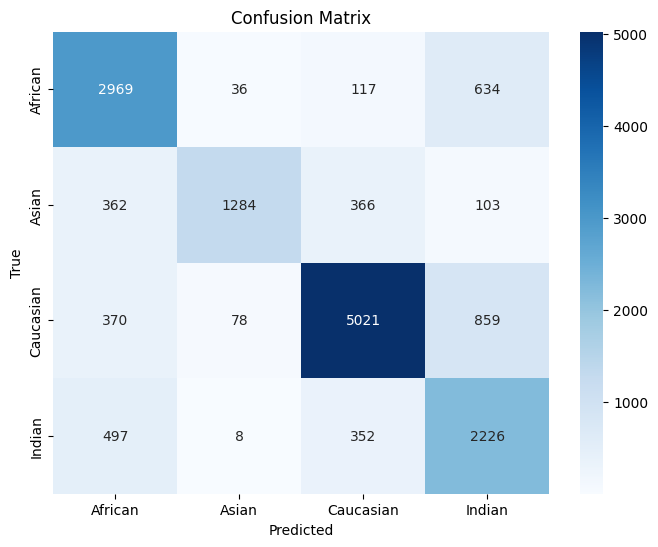

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Define the number of classes and input shape
num_classes = 4  # 4 classes: African, Asian, Caucasian, Indian
input_shape = (146, 86, 1)  # Grayscale image dimensions
# Load the model
model = tf.keras.models.load_model('/content/drive/MyDrive/race3_prediction_model_complex.h5')

# Data preprocessing for the test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/Preprocessed2',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    color_mode='grayscale',  # Specify grayscale
    class_mode='categorical',
    shuffle=False)

# Generate predictions
predictions = model.predict(test_generator)

# Convert the predicted probabilities to class labels
predicted_labels = [int(tf.argmax(prediction).numpy()) for prediction in predictions]

# Get the true labels
true_labels = test_generator.classes

# Calculate and print classification metrics
print(classification_report(true_labels, predicted_labels))

# Calculate and print the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)
print(confusion_mat)

# Plot a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (86, 146))
    image = np.expand_dims(image, axis=-1)
    image = image / 255.0
    return image

def run_model_on_images(model, processed_folder, class_labels):
    for file in os.listdir(processed_folder):
        image_path = os.path.join(processed_folder, file)
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            processed_image = load_and_preprocess_image(image_path)
            processed_image = np.expand_dims(processed_image, axis=0)

            prediction = model.predict(processed_image)
            predicted_class = np.argmax(prediction, axis=1)[0]

            # Print the predicted class and associated label
            print(f"File: {file}, Predicted Class: {predicted_class}, Label: {class_labels[predicted_class]}")

# Load the pre-trained model
model_path = "/content/drive/MyDrive/race_prediction_model_complex.h5"
prediction_model = load_model(model_path)

# Specify the path to the processed images folder
processed_folder = "/content/Preprocessed"

# Assuming you have a list of class labels corresponding to the model's output classes
class_labels = ["African", "Asian", "Cacausian", "Indian"]

# Run the model on the processed images
run_model_on_images(prediction_model, processed_folder, class_labels)


1/1 [==============================] - 8s 8s/step
File: 26_1_3_20170119193145481.jpg.chip.jpg, Predicted Class: 3, Label: Indian
1/1 [==============================] - 0s 29ms/step
File: 25_0_3_20170119171838017.jpg.chip.jpg, Predicted Class: 3, Label: Indian
1/1 [==============================] - 0s 20ms/step
File: 26_1_1_20170112235926962.jpg.chip.jpg, Predicted Class: 0, Label: African
1/1 [==============================] - 0s 18ms/step
File: 32_1_1_20170117134811472.jpg.chip.jpg, Predicted Class: 0, Label: African
1/1 [==============================] - 0s 19ms/step
File: 50_0_0_20170117155052592.jpg.chip.jpg, Predicted Class: 2, Label: Cacausian
1/1 [==============================] - 0s 21ms/step
File: 21_1_3_20170104222522503.jpg.chip.jpg, Predicted Class: 0, Label: African
1/1 [==============================] - 0s 22ms/step
File: 22_1_2_20170116172613537.jpg.chip.jpg, Predicted Class: 1, Label: Asian
1/1 [==============================] - 0s 21ms/step
File: 38_0_0_201701051840436

KeyboardInterrupt: ignored